In [1]:
import json
import glob
import calendar
from statistics import mean 
import statistics


In [2]:
import numpy as np 
import pandas as pd                  # for DataFrames
from numpy.linalg import eig
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

In [3]:
from sklearn import preprocessing

In [4]:
import scipy.fftpack                 # discrete Fourier transforms
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import chirp, peak_widths


In [5]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import os

In [6]:
root = "/Users/shehjarsadhu/Desktop/UniversityOfRhodeIsland/Graduate/WBL/Project_IOTEX/iotex-glove/PD/"
# Write all the results outside of the PD data folder.
root_results_write = "/Users/shehjarsadhu/Desktop/UniversityOfRhodeIsland/Graduate/WBL/Project_IOTEX/iotex-glove/"



In [8]:
# Returns a list of filepaths and date IDs at which the exercises were performed.
def plotting_raw(participant_id,results_file_name):
    np.set_printoptions(suppress=True) # to get only numeric notations. 
    df_rg_paths = pd.read_csv(root_results_write + results_file_name) # reaults_file - results_p2.csv
    df_rg_paths = df_rg_paths.sort_values(by=['FileName'])
    # print(df_rg_paths["Participant"])
    df_rg_paths = df_rg_paths[df_rg_paths["Participant"]==participant_id]
    df_rg_paths = df_rg_paths[df_rg_paths["NOT"]!="X"]
    df_rg_paths = df_rg_paths[df_rg_paths["MedStatus"]!="X"]
    df_rg_paths["Stage1_Random_Peaks"] = np.linspace(-911, -911, num=df_rg_paths.shape[0], endpoint=False)
    df_rg_paths["Method1_TimeBased_Peaks"] = np.linspace(-911, -911, num=df_rg_paths.shape[0], endpoint=False)
    df_rg_paths["Method3_FreqBased_Peaks"] = np.linspace(-911, -911, num=df_rg_paths.shape[0], endpoint=False)
    df_rg_paths["width_threshold"] = np.linspace(-911, -911, num=df_rg_paths.shape[0], endpoint=False)
    df_rg_paths["SNR_mean_std"] = np.linspace(-911, -911, num=df_rg_paths.shape[0], endpoint=False)
    df_rg_paths['SNR_Filtered'] = np.linspace(-911, -911, num=df_rg_paths.shape[0], endpoint=False)
    peak2peak_diff_freq_list = []
    peak2peak_diff_time_list = []
    file_name_list = []
    for index, row in df_rg_paths.iterrows():
        print("",index, row["Participant"] +"/"+ row["DateList"] + "/" + row["FileName"],"===========================")
        if row["FileName"] != "rg_20210703-070405.csv":
            if row["FileName"] != "lg_20211029-153037.csv":
                df = pd.read_csv(root+row["Participant"] +"/"+ row["DateList"] + "/" + row["FileName"])
                df_med = pd.read_fwf(root+row["Participant"] +"/"+ row["DateList"] + "/" + row["MedStatus"],header=None,ignore_index = True)
                df_rg_paths.at[index,'tremor'] = int(df_med.loc[0].values[0].split("=")[1])
                df_rg_paths.at[index,'dyskinesia'] =int(df_med.loc[1].values[0].split("=")[1])
                df_rg_paths.at[index,'bands_difficulty'] =int(df_med.loc[2].values[0].split("=")[1])
                df_rg_paths.at[index,'sleep_quality'] =int(df_med.loc[3].values[0].split("=")[1])
                df_rg_paths.at[index,'time_since_medication'] =df_med.loc[4].values[0].split("=")[1]
                df_rg_paths.at[index,'feel_medication'] =df_med.loc[5].values[0].split("=")[1]
                # , '2_to_3_hrs', '1_to_2_hrs', #'0_to_1_hrs','4_plus'
                if df_med.loc[4].values[0].split("=")[1] == "4_plus" or df_med.loc[4].values[0].split("=")[1] == "0_to_1_hrs":
                    df_rg_paths.at[index,'med_on_off'] = 0 # MED OFF
                if df_med.loc[4].values[0].split("=")[1] == "1_to_2_hrs" or df_med.loc[4].values[0].split("=")[1] == "2_to_3_hrs":
                    df_rg_paths.at[index,'med_on_off'] = 1 # MED ON
                    
#         # Subset the Finger tapping activity.
        #################### ------------------------ SUBSET DATA ------------------------ ####################
        if row["FileName"].startswith("rg_"):
            df_finger_tapping = df[df["activity"]==1]
        if row["FileName"].startswith("lg_"):
             df_finger_tapping = df[df["activity"]==0]
        #################### ------------------------ PREPROCESSING ------------------------ ####################
        if df_finger_tapping.shape[0]>0: # If data is present.
            st_time = df_finger_tapping["time"].iloc[0]
            stop_time = df_finger_tapping["time"].iloc[df_finger_tapping.shape[0]-1]
            total_time_nano = stop_time - st_time
            total_sec = total_time_nano/1000000000
            Fs = df_finger_tapping.shape[0]/round(total_sec, 2) # int(total_sec)
            print("Sampling Frequency (Fs =): ", Fs)
            num_samples_2 = Fs*2.5
            print("num_samples_2: Fs*2.5 ",num_samples_2)
            # Subset 2.5 seconds of data.
            start_idx = 100
            end_idx = start_idx+int(num_samples_2) 
            if int(num_samples_2)>=30: # Number of samples should be >= 30. 
                df_finger_tapping_2_5 = df_finger_tapping[start_idx:end_idx]*-1 # invert the signal *-1.
                # Normalize the  raw index finger values.
                # take df_finger_tapping_2_5_index_norm[0] to get the actual array of values of lingth 160.
                fig, axs  = plt.subplots(1, 1)
                plt.subplots_adjust(wspace=2,hspace=1.4,top=1,right =1.5) # top=0.8-> for top title spacing
                axs.plot(df_finger_tapping_2_5["index"],color="red",label  = "Raw Data")
                axs.set_title("Participant 4: " + row["FileName"] ,fontweight="bold")
                plt.show()
    # %whos
    return df_rg_paths  # Row is Session number, columsn are peak indexes



 0 Participant4/2021-10-18/lg_20211018-184648.csv ===========================
Sampling Frequency (Fs =):  92.78642149929279
num_samples_2: Fs*2.5  231.96605374823196


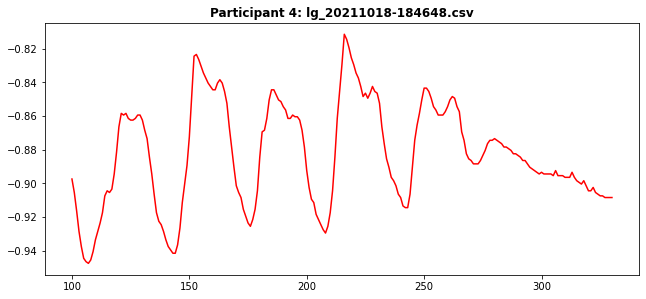

 1 Participant4/2021-10-19/lg_20211019-172844.csv ===========================
Sampling Frequency (Fs =):  92.67461669505963
num_samples_2: Fs*2.5  231.68654173764907


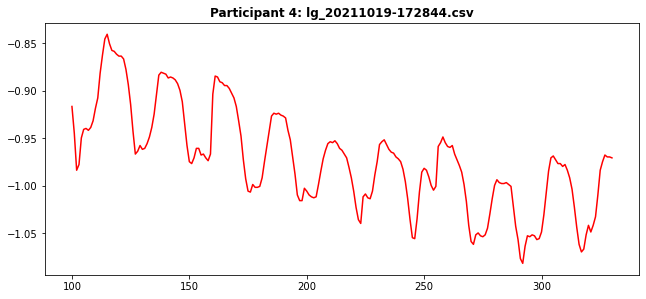

 2 Participant4/2021-10-19/lg_20211019-214518.csv ===========================
 3 Participant4/2021-10-20/lg_20211020-105349.csv ===========================
Sampling Frequency (Fs =):  91.06967615309127
num_samples_2: Fs*2.5  227.67419038272817


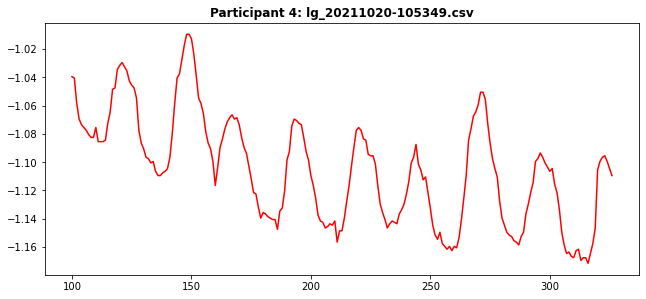

 5 Participant4/2021-10-21/lg_20211021-165751.csv ===========================
Sampling Frequency (Fs =):  92.62371615312792
num_samples_2: Fs*2.5  231.5592903828198


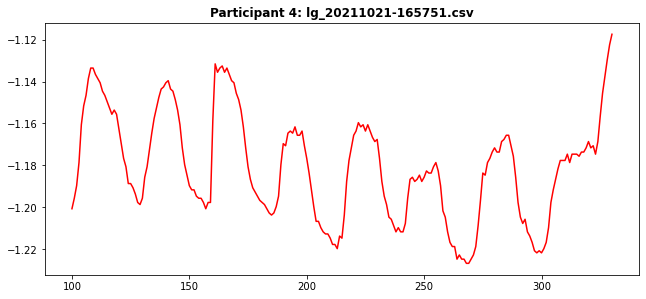

 6 Participant4/2021-10-22/lg_20211022-053129.csv ===========================
Sampling Frequency (Fs =):  175.82417582417582
num_samples_2: Fs*2.5  439.5604395604396


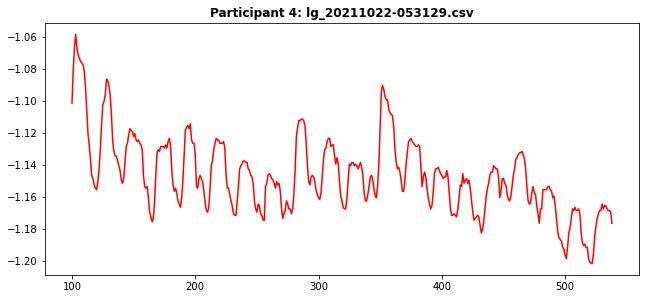

 7 Participant4/2021-10-22/lg_20211022-133556.csv ===========================
Sampling Frequency (Fs =):  93.17561419472247
num_samples_2: Fs*2.5  232.93903548680618


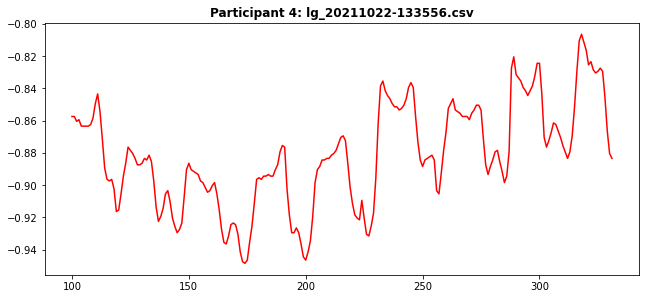

 11 Participant4/2021-10-27/lg_20211027-184737.csv ===========================
Sampling Frequency (Fs =):  95.8257713248639
num_samples_2: Fs*2.5  239.56442831215975


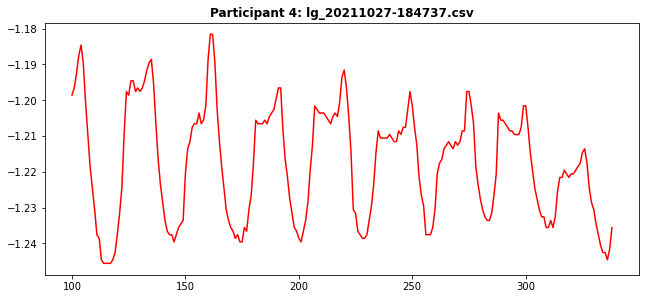

 12 Participant4/2021-10-28/lg_20211028-115244.csv ===========================
Sampling Frequency (Fs =):  76.63088356729976
num_samples_2: Fs*2.5  191.5772089182494


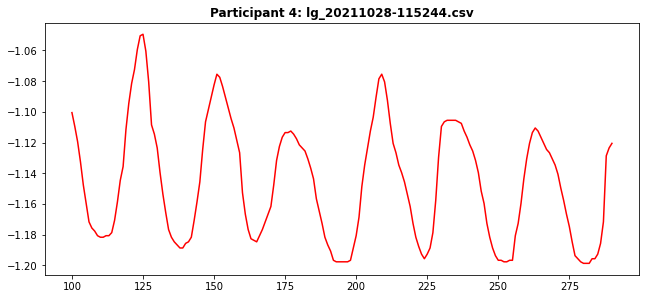

 13 Participant4/2021-10-28/lg_20211028-175651.csv ===========================
Sampling Frequency (Fs =):  97.50692520775623
num_samples_2: Fs*2.5  243.76731301939057


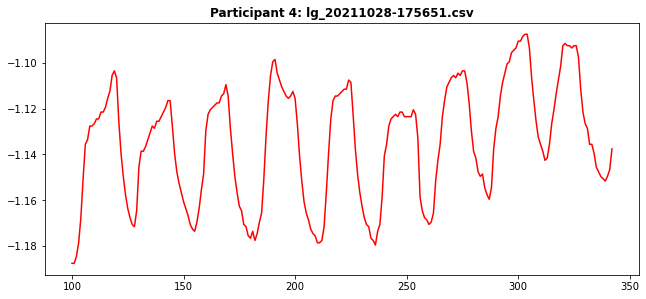

 14 Participant4/2021-10-29/lg_20211029-153037.csv ===========================
Sampling Frequency (Fs =):  97.50692520775623
num_samples_2: Fs*2.5  243.76731301939057


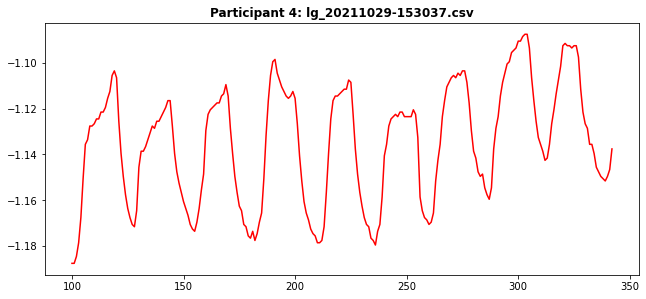

 15 Participant4/2021-10-29/lg_20211029-182954.csv ===========================
Sampling Frequency (Fs =):  96.96969696969697
num_samples_2: Fs*2.5  242.42424242424244


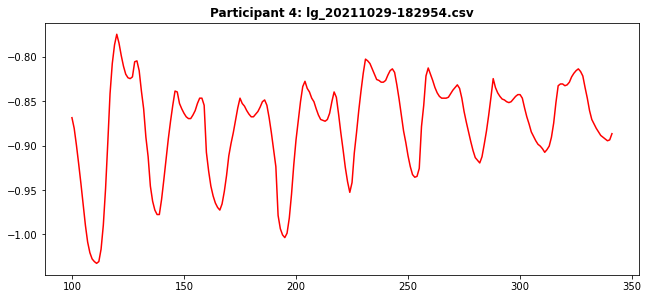

 16 Participant4/2021-10-30/lg_20211030-095315.csv ===========================
Sampling Frequency (Fs =):  95.52238805970148
num_samples_2: Fs*2.5  238.8059701492537


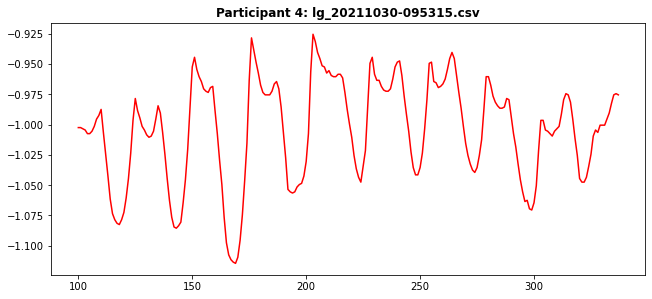

 17 Participant4/2021-10-30/lg_20211030-185943.csv ===========================
Sampling Frequency (Fs =):  94.85614646904969
num_samples_2: Fs*2.5  237.14036617262423


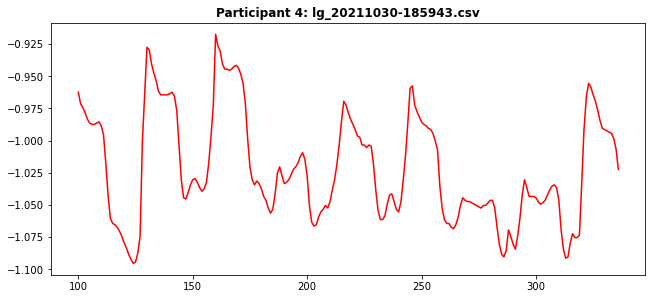

 18 Participant4/2021-10-31/lg_20211031-133028.csv ===========================
Sampling Frequency (Fs =):  93.94495412844036
num_samples_2: Fs*2.5  234.8623853211009


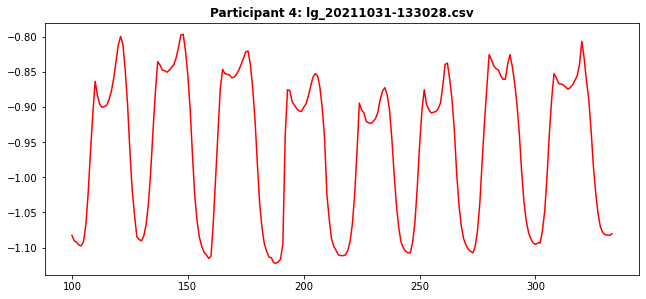

 19 Participant4/2021-10-31/lg_20211031-190553.csv ===========================
Sampling Frequency (Fs =):  94.3778801843318
num_samples_2: Fs*2.5  235.9447004608295


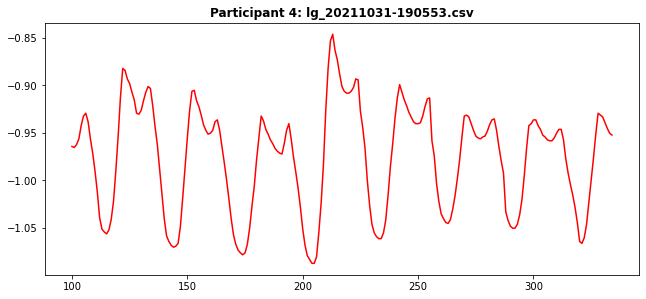

 20 Participant4/2021-10-18/rg_20211018-184648.csv ===========================
Sampling Frequency (Fs =):  93.32079021636876
num_samples_2: Fs*2.5  233.30197554092192


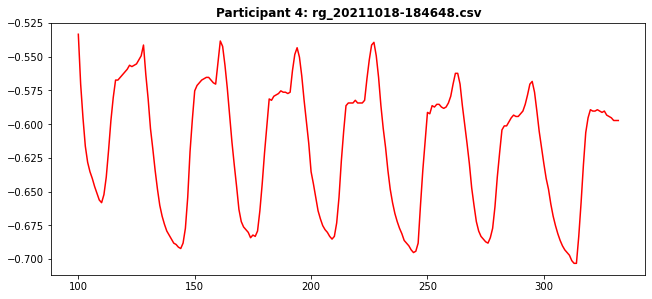

 21 Participant4/2021-10-19/rg_20211019-172844.csv ===========================
Sampling Frequency (Fs =):  91.69054441260744
num_samples_2: Fs*2.5  229.2263610315186


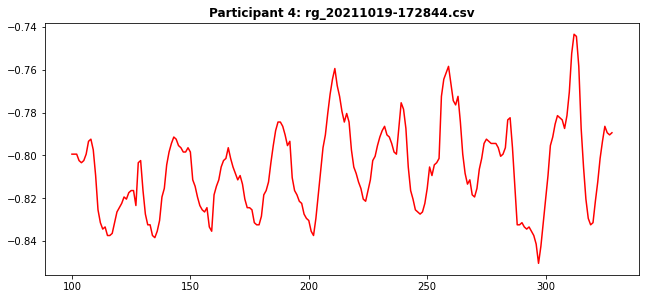

 22 Participant4/2021-10-19/rg_20211019-214518.csv ===========================
 23 Participant4/2021-10-20/rg_20211020-105349.csv ===========================
Sampling Frequency (Fs =):  95.20153550863724
num_samples_2: Fs*2.5  238.00383877159308


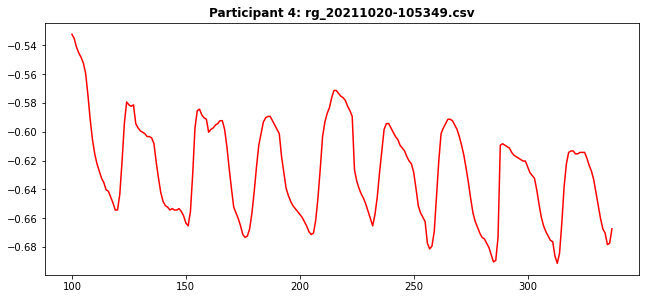

 24 Participant4/2021-10-20/rg_20211020-190820.csv ===========================
Sampling Frequency (Fs =):  92.66409266409266
num_samples_2: Fs*2.5  231.66023166023166


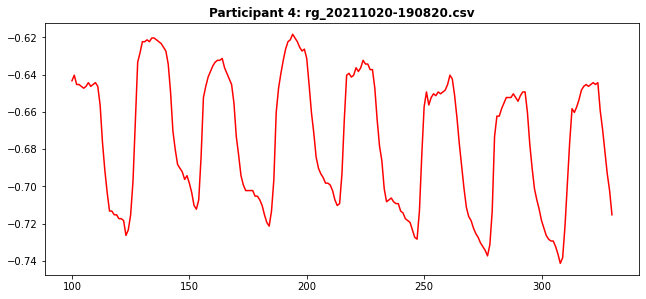

 25 Participant4/2021-10-21/rg_20211021-165751.csv ===========================
Sampling Frequency (Fs =):  91.34157944814463
num_samples_2: Fs*2.5  228.35394862036156


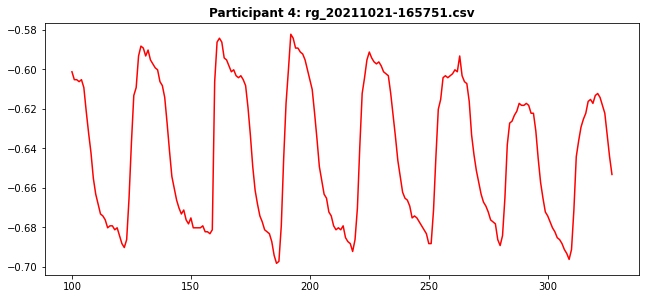

 26 Participant4/2021-10-22/rg_20211022-053129.csv ===========================
Sampling Frequency (Fs =):  92.13051823416507
num_samples_2: Fs*2.5  230.32629558541265


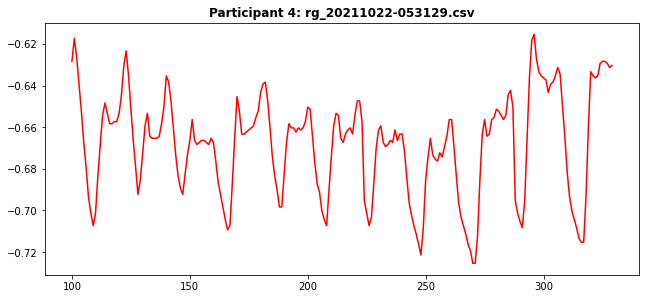

 27 Participant4/2021-10-22/rg_20211022-133556.csv ===========================
Sampling Frequency (Fs =):  94.20702754036088
num_samples_2: Fs*2.5  235.5175688509022


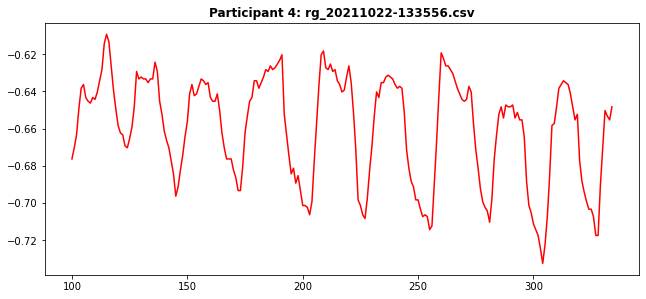

 31 Participant4/2021-10-27/rg_20211027-184737.csv ===========================
Sampling Frequency (Fs =):  95.16728624535317
num_samples_2: Fs*2.5  237.91821561338293


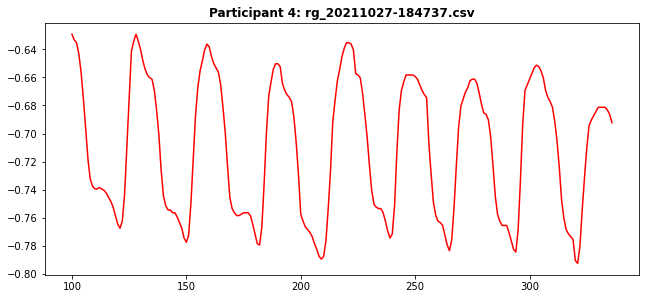

 33 Participant4/2021-10-28/rg_20211028-175651.csv ===========================
Sampling Frequency (Fs =):  92.21902017291066
num_samples_2: Fs*2.5  230.54755043227664


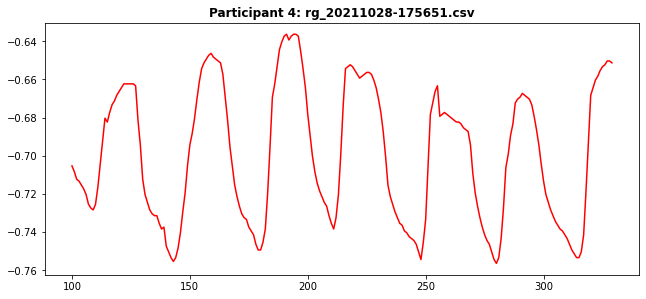

 34 Participant4/2021-10-29/rg_20211029-153037.csv ===========================
Sampling Frequency (Fs =):  94.3778801843318
num_samples_2: Fs*2.5  235.9447004608295


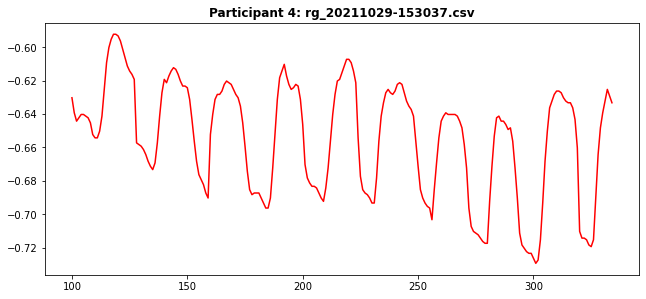

 35 Participant4/2021-10-29/rg_20211029-182954.csv ===========================
Sampling Frequency (Fs =):  96.17486338797814
num_samples_2: Fs*2.5  240.43715846994533


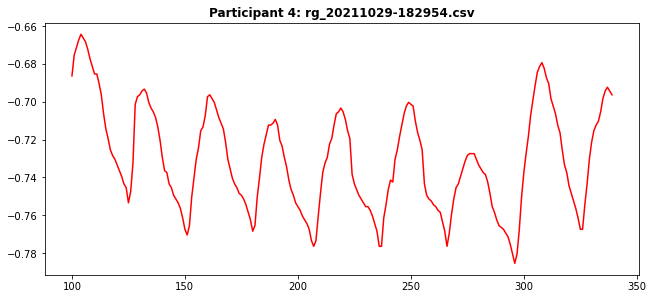

 36 Participant4/2021-10-30/rg_20211030-095315.csv ===========================
Sampling Frequency (Fs =):  97.35788630904723
num_samples_2: Fs*2.5  243.39471577261807


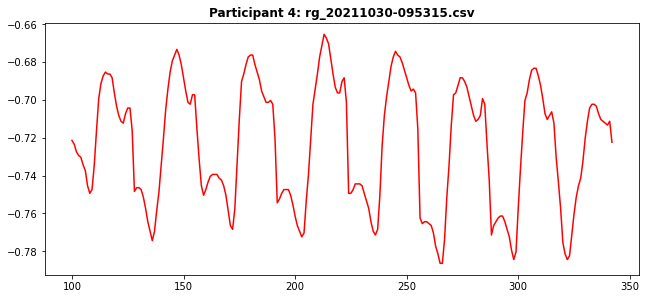

 37 Participant4/2021-10-30/rg_20211030-185943.csv ===========================
Sampling Frequency (Fs =):  93.57495881383855
num_samples_2: Fs*2.5  233.93739703459636


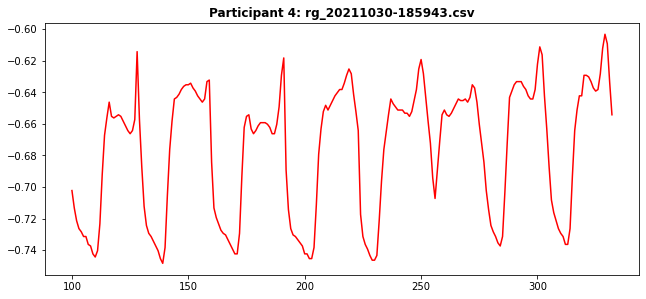

 38 Participant4/2021-10-31/rg_20211031-133028.csv ===========================
Sampling Frequency (Fs =):  95.02183406113538
num_samples_2: Fs*2.5  237.55458515283846


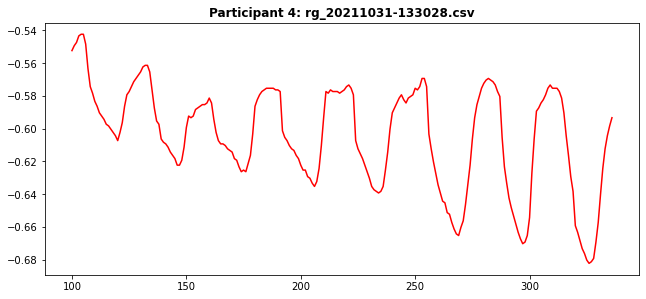

 39 Participant4/2021-10-31/rg_20211031-190553.csv ===========================
Sampling Frequency (Fs =):  97.15370018975332
num_samples_2: Fs*2.5  242.8842504743833


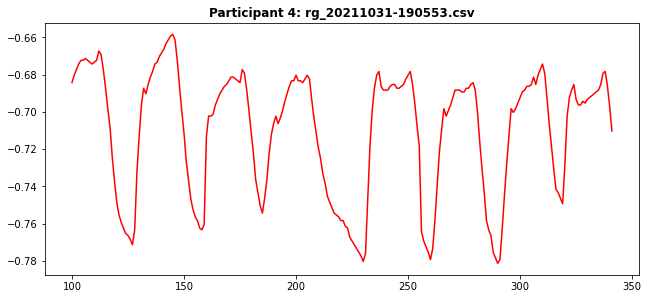

In [9]:
results_p4 = plotting_raw("Participant4","results_p4.csv")
# Skipped file due to inefficient sampling rate. 0
results_p4 = results_p4[results_p4["FileName"] != "lg_20211029-153037.csv"]
